In [46]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from pandas import to_datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
from numpy import array
from numpy import concatenate

# Baseline(LSTM1)

In [2]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]


In [3]:
df = read_csv('cm_all_1.csv', header=0, squeeze=True)
df.head()

,Unnamed: 0,ts,cpu_ghz,cpu_usage,cpu_idle,cpu_total,memory_free_mb,memory_usage,memory_total,period,weekday_tag,workday_tag,cpu_usage_tag,memory_usage_tag
0,1,2017-08-04 07:09:00,1.622994,0.058949,7229.349138,7626.006979,73703.339671,0.171460,85762.997397,night,5,0,0,-3
1,2,2017-08-04 07:10:00,1.565744,0.051145,7436.343501,7808.899014,73678.012357,0.171868,85762.997397,night,5,0,-2,-3
2,3,2017-08-04 07:11:00,1.532764,0.050431,7266.985222,7628.050287,73679.538946,0.171852,85762.997397,night,5,0,-2,-3
3,4,2017-08-04 07:12:00,1.537919,0.055125,7251.151273,7645.735222,73662.632567,0.171941,85762.997397,night,5,0,-1,-3
4,5,2017-08-04 07:13:00,1.535036,0.049197,7272.412151,7618.750821,73644.415185,0.172063,85762.997397,night,5,0,-2,-3


In [4]:
df = df.drop(df.columns[0],axis=1)
df.head(2)

,ts,cpu_ghz,cpu_usage,cpu_idle,cpu_total,memory_free_mb,memory_usage,memory_total,period,weekday_tag,workday_tag,cpu_usage_tag,memory_usage_tag
0,2017-08-04 07:09:00,1.622994,0.058949,7229.349138,7626.006979,73703.339671,0.171460,85762.997397,night,5,0,0,-3
1,2017-08-04 07:10:00,1.565744,0.051145,7436.343501,7808.899014,73678.012357,0.171868,85762.997397,night,5,0,-2,-3


In [5]:
df.ts = to_datetime(df.ts)
df = df.set_index(['ts'])
df.head(3)


,cpu_ghz,cpu_usage,cpu_idle,cpu_total,memory_free_mb,memory_usage,memory_total,period,weekday_tag,workday_tag,cpu_usage_tag,memory_usage_tag
ts,,,,,,,,,,,,
2017-08-04 07:09:00,1.622994,0.058949,7229.349138,7626.006979,73703.339671,0.171460,85762.997397,night,5,0,0,-3
2017-08-04 07:10:00,1.565744,0.051145,7436.343501,7808.899014,73678.012357,0.171868,85762.997397,night,5,0,-2,-3
2017-08-04 07:11:00,1.532764,0.050431,7266.985222,7628.050287,73679.538946,0.171852,85762.997397,night,5,0,-2,-3


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5499 entries, 2017-08-04 07:09:00 to 2017-08-08 02:47:00
Data columns (total 12 columns):
cpu_ghz             5499 non-null float64
cpu_usage           5499 non-null float64
cpu_idle            5499 non-null float64
cpu_total           5499 non-null float64
memory_free_mb      5499 non-null float64
memory_usage        5499 non-null float64
memory_total        5499 non-null float64
period              5499 non-null object
weekday_tag         5499 non-null int64
workday_tag         5499 non-null int64
cpu_usage_tag       5499 non-null int64
memory_usage_tag    5499 non-null int64
dtypes: float64(7), int64(4), object(1)
memory usage: 558.5+ KB


In [7]:
series = df["cpu_usage_tag"]

In [8]:
series

ts
2017-08-04 07:09:00    0
2017-08-04 07:10:00   -2
2017-08-04 07:11:00   -2
2017-08-04 07:12:00   -1
2017-08-04 07:13:00   -2
2017-08-04 07:14:00   -2
2017-08-04 07:15:00    0
2017-08-04 07:16:00    0
2017-08-04 07:17:00   -1
2017-08-04 07:18:00   -2
2017-08-04 07:19:00   -3
2017-08-04 07:20:00   -3
2017-08-04 07:21:00   -3
2017-08-04 07:22:00   -2
2017-08-04 07:23:00   -3
2017-08-04 07:24:00   -1
2017-08-04 07:25:00    4
2017-08-04 07:26:00    3
2017-08-04 07:27:00   -2
2017-08-04 07:28:00    0
2017-08-04 07:29:00    0
2017-08-04 07:30:00   -3
2017-08-04 07:31:00   -3
2017-08-04 07:32:00   -3
2017-08-04 07:33:00   -3
2017-08-04 07:34:00   -3
2017-08-04 07:35:00   -3
2017-08-04 07:36:00    0
2017-08-04 07:37:00    0
2017-08-04 07:38:00   -1
                      ..
2017-08-08 02:18:00   -1
2017-08-08 02:19:00   -1
2017-08-08 02:20:00   -2
2017-08-08 02:21:00   -1
2017-08-08 02:22:00   -1
2017-08-08 02:23:00    0
2017-08-08 02:24:00    0
2017-08-08 02:25:00    1
2017-08-08 02:26:00   

In [9]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

In [10]:
type(raw_values)

numpy.ndarray

In [11]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [12]:
train_data_number = round(len(supervised_values) * 0.2)
train_data_number

1100

In [13]:
# split data into train and test-sets
train, test = supervised_values[:train_data_number], supervised_values[train_data_number:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)


In [15]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
	print("repeats")
	# fit the model
	lstm_model = fit_lstm(train_scaled, 1, 60, 4)
	# forecast the entire training dataset to build up state for forecasting
	train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
	lstm_model.predict(train_reshaped, batch_size=1)
	# walk-forward validation on the test data
	predictions = list()
	for i in range(len(test_scaled)):     
		# make one-step forecast
		X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
		yhat = forecast_lstm(lstm_model, 1, X)
		# invert scaling
		yhat = invert_scale(scaler, X, yhat)
		# invert differencing
		yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
		# store forecast
		predictions.append(yhat)
	# report performance
	rmse = sqrt(mean_squared_error(raw_values[train_data_number+1:], predictions))
	print('%d) Test RMSE: %.3f' % (r+1, rmse))
	error_scores.append(rmse)



repeats
1) Test RMSE: 1.084
repeats
2) Test RMSE: 0.857
repeats
3) Test RMSE: 1.361
repeats
4) Test RMSE: 3.222
repeats
5) Test RMSE: 6.935
repeats
6) Test RMSE: 0.852
repeats
7) Test RMSE: 0.863
repeats
8) Test RMSE: 0.949
repeats
9) Test RMSE: 16.218
repeats
10) Test RMSE: 1.038
repeats
11) Test RMSE: 0.831
repeats
12) Test RMSE: 0.883
repeats
13) Test RMSE: 0.938
repeats
14) Test RMSE: 1.105
repeats
15) Test RMSE: 1.728
repeats
16) Test RMSE: 0.843
repeats
17) Test RMSE: 0.845
repeats
18) Test RMSE: 0.942
repeats
19) Test RMSE: 1.260
repeats
20) Test RMSE: 0.760
repeats
21) Test RMSE: 6.573
repeats
22) Test RMSE: 1.022
repeats
23) Test RMSE: 1.019
repeats
24) Test RMSE: 0.945
repeats
25) Test RMSE: 1.522
repeats
26) Test RMSE: 0.898
repeats
27) Test RMSE: 0.798
repeats
28) Test RMSE: 0.787
repeats
29) Test RMSE: 0.937
repeats
30) Test RMSE: 2.053


            rmse
count  30.000000
mean    2.002247
std     3.080020
min     0.759843
25%     0.858611
50%     0.946818
75%     1.335993
max    16.217533


/home/tu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


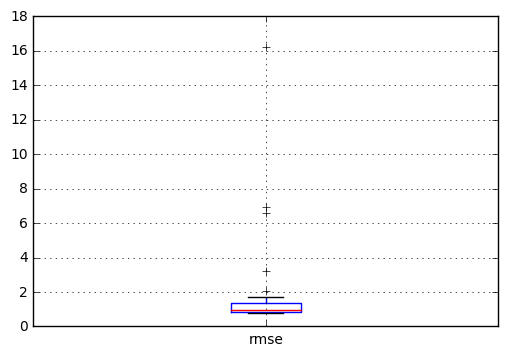

In [16]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

# Lstm2

In [56]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [57]:
df = read_csv('cm_all_1.csv', header=0, squeeze=True)
df = df.drop(df.columns[0],axis=1)
df.ts = to_datetime(df.ts)
df = df.set_index(['ts'])
df.head(2)

,cpu_ghz,cpu_usage,cpu_idle,cpu_total,memory_free_mb,memory_usage,memory_total,period,weekday_tag,workday_tag,cpu_usage_tag,memory_usage_tag
ts,,,,,,,,,,,,
2017-08-04 07:09:00,1.622994,0.058949,7229.349138,7626.006979,73703.339671,0.171460,85762.997397,night,5,0,0,-3
2017-08-04 07:10:00,1.565744,0.051145,7436.343501,7808.899014,73678.012357,0.171868,85762.997397,night,5,0,-2,-3


In [58]:
values = df.values

In [59]:
# integer encode direction
# tu: transform all your tag 
encoder = LabelEncoder()
values[:,-1] = encoder.fit_transform(values[:,-1])
values[:,-2] = encoder.fit_transform(values[:,-2])
values[:,-3] = encoder.fit_transform(values[:,-2])
values[:,-4] = encoder.fit_transform(values[:,-2])
values[:,-5] = encoder.fit_transform(values[:,-5])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [60]:
# specify the number of lag hours
# tu : n_min =set time lag how earlier data will you use to predict current data
n_min = 3
n_features = len(df.columns)

In [61]:
# frame as supervised learning
# series_to_supervised function is used to produce earlier data
reframed = series_to_supervised(scaled, n_min, 1)
print(reframed.shape)

(5496, 48)


In [62]:
#check dataframe processed by series_to_supervised function
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t)
3,0.675438,0.178166,0.746099,0.141518,0.824924,0.226678,0.0,0.75,0.428571,0.428571,...,0.771196,0.216026,0.810045,0.243593,0.0,0.75,0.285714,0.285714,0.285714,0.0
4,0.384414,0.070833,0.984388,0.832260,0.815670,0.241034,0.0,0.75,0.142857,0.142857,...,0.795671,0.114113,0.803387,0.247914,0.0,0.75,0.142857,0.142857,0.142857,0.0
5,0.216763,0.061021,0.789425,0.149235,0.816225,0.240459,0.0,0.75,0.142857,0.142857,...,0.792730,0.112547,0.806696,0.244091,0.0,0.75,0.142857,0.142857,0.142857,0.0
6,0.242970,0.125575,0.771196,0.216026,0.810045,0.243593,0.0,0.75,0.285714,0.285714,...,0.710845,0.128136,0.811136,0.238269,0.0,0.75,0.428571,0.428571,0.428571,0.0
7,0.228314,0.044047,0.795671,0.114113,0.803387,0.247914,0.0,0.75,0.142857,0.142857,...,0.687066,0.091911,0.807299,0.240543,0.0,0.75,0.428571,0.428571,0.428571,0.0


In [63]:
# preserve original data, this dataframe will be used to calculate RMSE 
#between y_prediction and y_realdata in the last two code cells

original_data = reframed[reframed.columns[n_features*n_min:]]
len(original_data.columns)

12

In [64]:
# set list used to preserve only data what you want to predict
# what to predict is the remove one is this list

unused_col = [("var%d(t)"%i) for i in range(1,n_features+1)]
unused_col.remove('var11(t)')

In [65]:
# use drop code to delete other current data except what you want to predict
reframed1 = reframed.drop(unused_col,axis =1)
reframed1.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var11(t)
3,0.675438,0.178166,0.746099,0.141518,0.824924,0.226678,0.0,0.75,0.428571,0.428571,...,0.149235,0.816225,0.240459,0.0,0.75,0.142857,0.142857,0.142857,0.0,0.285714
4,0.384414,0.070833,0.984388,0.832260,0.815670,0.241034,0.0,0.75,0.142857,0.142857,...,0.216026,0.810045,0.243593,0.0,0.75,0.285714,0.285714,0.285714,0.0,0.142857
5,0.216763,0.061021,0.789425,0.149235,0.816225,0.240459,0.0,0.75,0.142857,0.142857,...,0.114113,0.803387,0.247914,0.0,0.75,0.142857,0.142857,0.142857,0.0,0.142857
6,0.242970,0.125575,0.771196,0.216026,0.810045,0.243593,0.0,0.75,0.285714,0.285714,...,0.112547,0.806696,0.244091,0.0,0.75,0.142857,0.142857,0.142857,0.0,0.428571
7,0.228314,0.044047,0.795671,0.114113,0.803387,0.247914,0.0,0.75,0.142857,0.142857,...,0.128136,0.811136,0.238269,0.0,0.75,0.428571,0.428571,0.428571,0.0,0.428571


In [66]:
# split into train and test sets
values = reframed1.values
train_data_number = 1100 #set number as lstm1
train = values[:train_data_number, :]
test = values[train_data_number:, :]

In [67]:
n_obs = n_min * n_features
train_X, train_y = train[:, :n_obs], train[:,n_obs:]
test_X, test_y = test[:, :n_obs], test[:,n_obs:]
print(train_X.shape, len(train_X), train_y.shape)

(1100, 36) 1100 (1100, 1)


In [68]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_min, n_features))
test_X = test_X.reshape((test_X.shape[0], n_min, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1100, 3, 12) (1100, 1) (4396, 3, 12) (4396, 1)


In [69]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [75]:
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    history = model.fit(train_X, train_y, epochs=60 ,batch_size=1, validation_data=(test_X, test_y), verbose=2, shuffle=False)
    yhat = model.predict(test_X)
    # walk-forward validation on the test data
    predictions = list()
    
    # invert scaling for forecas
    # combine original scaled data and predicted answer, set the predicted answer to the 
    # original position
    original_test = original_data.iloc[train_data_number:]
    before = [("var%d(t)"%i)for i in range(1,11)]
    after = [("var%d(t)"%i)for i in range(12,n_features+1)]
    inv_yhat = concatenate((original_test[before],yhat,original_test[after]),axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,11]
    # invert scaling for actual
    original_test = original_data.iloc[train_data_number:]
    original_recover = scaler.inverse_transform(original_test)
    inv_y = original_recover[:,11]
    # invert differencing
    rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)



Train on 1100 samples, validate on 4396 samples
Epoch 1/60
16s - loss: 0.0977 - val_loss: 0.1125
Epoch 2/60
17s - loss: 0.0964 - val_loss: 0.1122
Epoch 3/60
13s - loss: 0.0954 - val_loss: 0.1096
Epoch 4/60
13s - loss: 0.0942 - val_loss: 0.1019
Epoch 5/60
12s - loss: 0.0930 - val_loss: 0.1046
Epoch 6/60
14s - loss: 0.0916 - val_loss: 0.1132
Epoch 7/60
12s - loss: 0.0898 - val_loss: 0.1088
Epoch 8/60
13s - loss: 0.0881 - val_loss: 0.0970
Epoch 9/60
12s - loss: 0.0851 - val_loss: 0.1078
Epoch 10/60
13s - loss: 0.0834 - val_loss: 0.0963
Epoch 11/60
14s - loss: 0.0819 - val_loss: 0.1124
Epoch 12/60
14s - loss: 0.0810 - val_loss: 0.0855
Epoch 13/60
15s - loss: 0.0798 - val_loss: 0.0899
Epoch 14/60
14s - loss: 0.0785 - val_loss: 0.0894
Epoch 15/60
13s - loss: 0.0770 - val_loss: 0.0820
Epoch 16/60
14s - loss: 0.0762 - val_loss: 0.0825
Epoch 17/60
14s - loss: 0.0747 - val_loss: 0.0798
Epoch 18/60
12s - loss: 0.0738 - val_loss: 0.0800
Epoch 19/60
14s - loss: 0.0733 - val_loss: 0.0806
Epoch 20/60

       rmse
count  30.0
mean    0.0
std     0.0
min     0.0
25%     0.0
50%     0.0
75%     0.0
max     0.0


/home/tu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


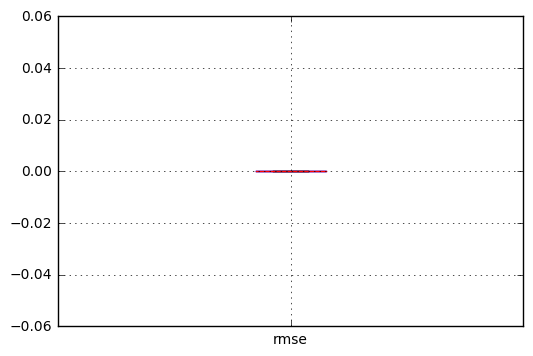

In [76]:
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()